In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
import numpy.fft as fft

import rf

import seismic.receiver_fn.rf_util as rf_util
import seismic.receiver_fn.rf_plot_utils as rf_plot_utils
import seismic.receiver_fn.rf_stacking as rf_stacking

In [2]:
# References:
# Yu, Y., J. Song, K. H. Liu, and S. S. Gao (2015), Determining crustal structure beneath seismic stations overlying a low-velocity
# sedimentary layer using receiver functions, J. Geophys. Res. Solid Earth, 120, 3208–3218, doi:10.1002/2014JB011610.
# http://dx.doi.org/10.1002/2014JB011610

## Data loading

In [3]:
rf_type = 'ZRT_it'
save_files = True

In [94]:
# network = 'AQ'
# target_station = 'AQT4'
network = 'OA'
target_station = 'CG21'
# network = '7X'
# target_station = 'MB11'

In [95]:
# src_file = r"/g/data/ha3/am7399/shared/AQT_RF_analysis/AQT_rfs_20151128T042000-20191108T000317_{}_rev1_qual.h5".format(rf_type)
src_file = r"/g/data/ha3/am7399/shared/OA_RF_analysis/OA_rfs_20170911T000036-20181128T230620_{}_rev15_qual.h5".format(rf_type)
# src_file = r"/g/data/ha3/am7399/shared/7X_RF_analysis/7X_rfs_20090616T034200-20110401T231849_{}_rev2_qual.h5".format(rf_type)

In [96]:
# data_all = rf_util.read_h5_rf(src_file, network, target_station)
data_all = rf_util.read_h5_rf(src_file, network, target_station, loc='0M')

In [97]:
data_all

132 Trace(s) in Stream:

Prf OA.CG21.0M.HHR | -50.0s - 150.0s onset:2017-11-07T09:08:23.160000Z | 10.0 Hz, 2001 samples | mag:5.5 dist:39.4 baz:96.2 slow:8.03
...
(130 other traces)
...
Prf OA.CG21.0M.HHT | -50.0s - 150.0s onset:2018-11-14T21:33:31.155000Z | 10.0 Hz, 2001 samples | mag:6.1 dist:75.7 baz:12.6 slow:5.72

[Use "print(Stream.__str__(extended=True))" to print all Traces]

## Select R-channel data

In [98]:
db = rf_util.rf_to_dict(data_all)

In [99]:
station_db = db[target_station]

In [100]:
channel = rf_util.choose_rf_source_channel(rf_type, station_db)
print("Selected channel: {}".format(channel))
channel_data = station_db[channel]
len(channel_data)

Selected channel: HHR


66

In [101]:
channel_data[0].stats.sampling_rate

10.0

In [102]:
rf_stream = rf.RFStream(channel_data).sort(['back_azimuth'])

## Quality filter the RFs

In [103]:
rf_util.label_rf_quality_simple_amplitude(rf_type, rf_stream)

In [104]:
# Only keep 'a' quality traces
rf_stream = rf.RFStream([tr for tr in rf_stream if tr.stats.predicted_quality == 'a'])

In [105]:
len(rf_stream)

47

In [106]:
# Do similarity filtering
rf_stream = rf_util.filter_crosscorr_coeff(rf_stream)
len(rf_stream)

40

## Plot initial data

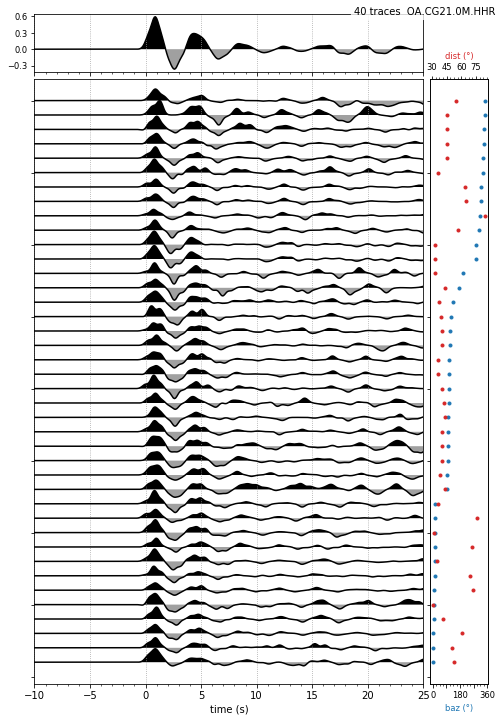

In [107]:
fig = rf_plot_utils.plot_rf_stack(rf_stream)
if save_files:
    fig.savefig("{}.{}_RFs_quality.png".format(network, target_station), dpi=300)
plt.show()

## Look at initial $H-k$ stack

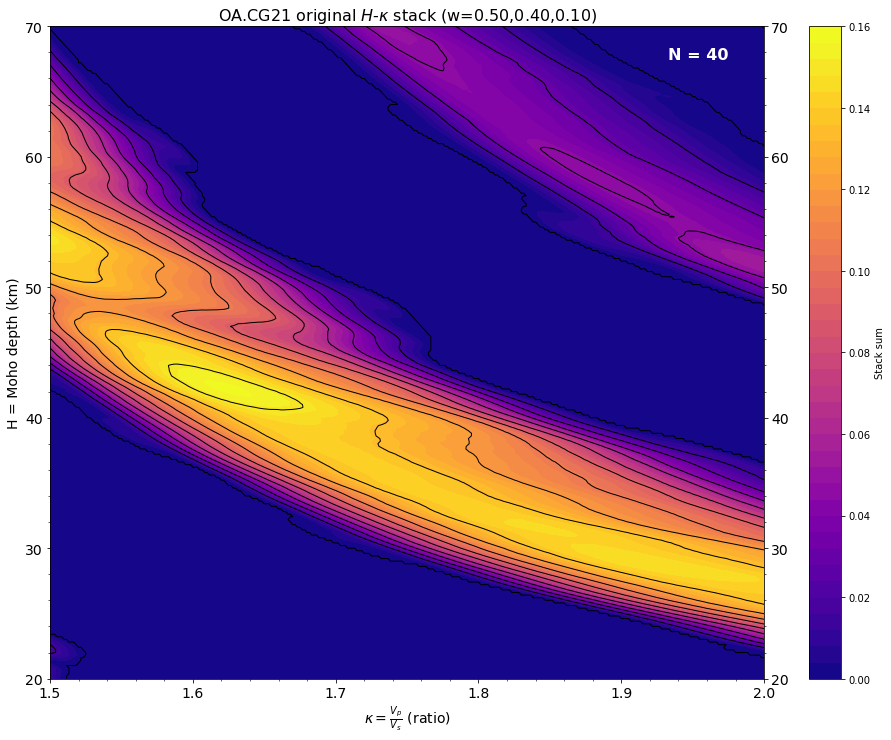

In [108]:
k_grid, h_grid, hk = rf_stacking.compute_hk_stack(rf_stream, include_t3=True, root_order=2,
                                                  k_range=np.linspace(1.5, 2.0, 301), V_p=6.4)
w = (0.5, 0.4, 0.1)
w_str = "w={:1.2f},{:1.2f},{:1.2f}".format(*w)
stack = rf_stacking.compute_weighted_stack(hk, weighting=w)
hk_fig = rf_plot_utils.plot_hk_stack(k_grid, h_grid, stack, num=len(rf_stream),
                                     title="{}.{} original $H$-$\kappa$ stack ({})".format(
                                         network, target_station, w_str))
if save_files:
    hk_fig.savefig("{}.{}_Hk_stack_original.png".format(network, target_station), dpi=300)
plt.show()

## Generate reverb removal filter

In [109]:
x = np.array([tr.data for tr in rf_stream])

In [110]:
ac = np.apply_along_axis(lambda _x: np.correlate(_x, _x, 'full')/np.dot(_x, _x), axis=1, arr=x)

In [111]:
ac_causal = ac[:, ac.shape[1]//2:]

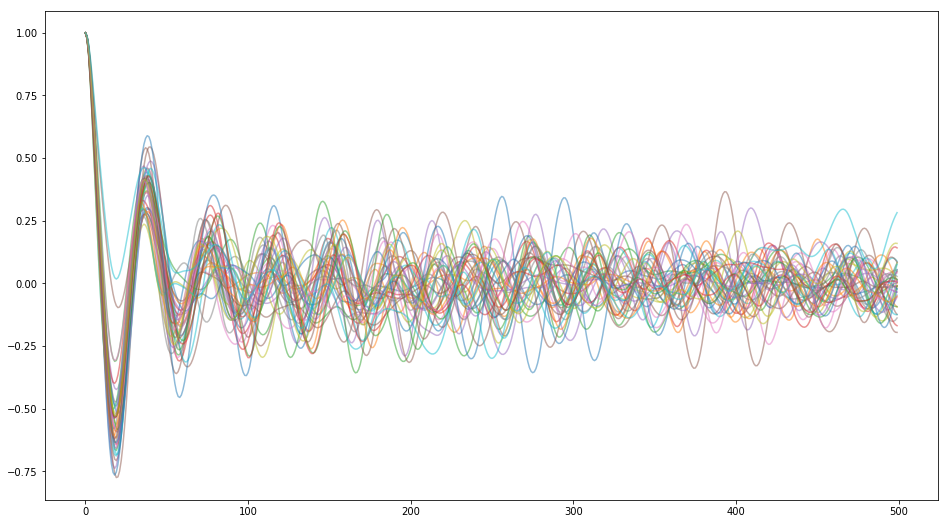

In [112]:
plt.figure(figsize=(16,9))
plt.plot(ac_causal[:, :500].T, alpha=0.5)
plt.show()
plt.close()

In [113]:
ac_extrema = np.apply_along_axis(lambda _x: signal.argrelextrema(_x, np.less)[0][0], axis=1, arr=ac_causal)
# ac_extrema

In [114]:
def reverb_removal_filter(offset, amplitude):
    reverb_removal_kernel = np.zeros(offset + 1)
    reverb_removal_kernel[0] = 1
    reverb_removal_kernel[-1] = amplitude
    return reverb_removal_kernel

In [115]:
de_reverb = [reverb_removal_filter(ac_extrema[i], -ac_causal[i, ac_extrema[i]]) for i in range(len(x))]

## Apply reverb removal filter

In [116]:
x_norev = [np.convolve(_x, de_reverb[i], 'full') for i, _x in enumerate(x)]

In [117]:
x_norev = [_x[:(-ac_extrema[i] + 1)] for i, _x in enumerate(x_norev)]

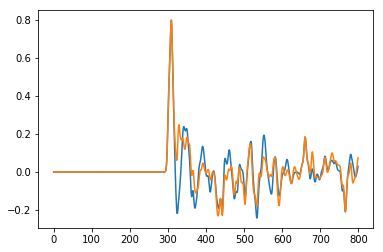

In [118]:
plt.plot(x[0,200:1000])
plt.plot(np.array(x_norev)[0,200:1000])
plt.show()

## Construct and plot RF stream from de-reverbed traces

In [119]:
traces = []
for i, tr in enumerate(rf_stream):
    new_tr = tr.copy()
    new_tr.data = x_norev[i]
    traces.append(new_tr)
# end for
rf_stream_noreverb = rf.RFStream(traces)

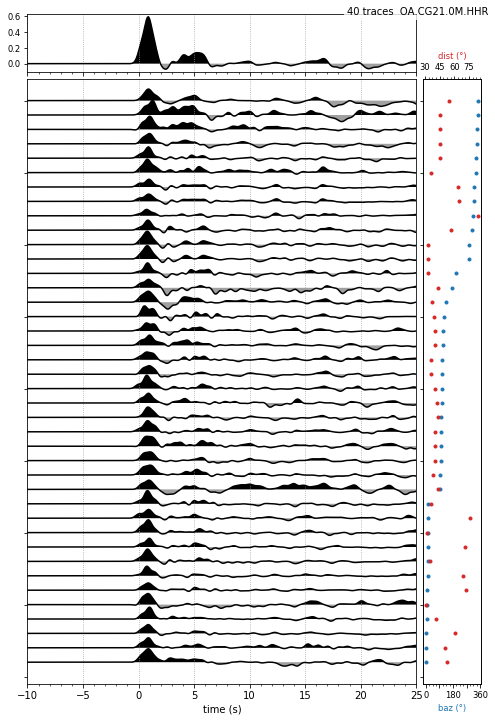

In [120]:
fig = rf_plot_utils.plot_rf_stack(rf_stream_noreverb)
if save_files:
    fig.savefig("{}.{}_RFs_dereverb.png".format(network, target_station), dpi=300)
plt.show()

## Look at H-k stacking of de-reverbed traces (no subsedimentary correction)

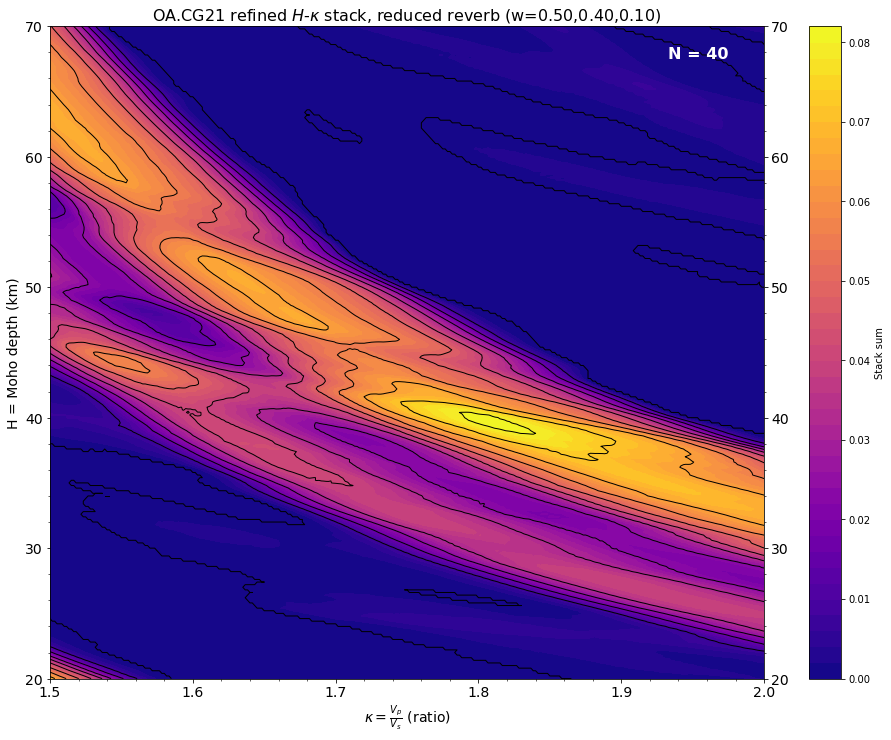

In [121]:
k_grid, h_grid, hk = rf_stacking.compute_hk_stack(rf_stream_noreverb, include_t3=True,
                                                  root_order=2, k_range=np.linspace(1.5, 2.0, 301), V_p=6.4)
w = (0.5, 0.4, 0.1)
w_str = "w={:1.2f},{:1.2f},{:1.2f}".format(*w)
stack = rf_stacking.compute_weighted_stack(hk, weighting=w)
hk_fig = rf_plot_utils.plot_hk_stack(k_grid, h_grid, stack, num=len(rf_stream_noreverb),
                                     title="{}.{} refined $H$-$\kappa$ stack, reduced reverb ({})".format(
                                         network, target_station, w_str))
plt.show()

## Determine subsediment crustal thickness using modified $H-k$ stacking

In [122]:
def estimate_Pbs_timedelta(tr):
    '''Estimate time delta to PbS phase arrival relative to P, using heuristic rules.
    '''
    lead_time = tr.stats.onset - tr.stats.starttime
    times_rel = tr.times() - lead_time
    mask = np.array((times_rel >= 0.0) & (times_rel <= 5.0))
    loc = np.nonzero(mask & (tr.data == np.max(tr.data[mask])))
    return tr.times()[loc[0][0]] - lead_time
# end func

In [123]:
for i, tr in enumerate(rf_stream_noreverb):
    pbs_delta = estimate_Pbs_timedelta(tr)
    tt_delta = ac_extrema[i]/tr.stats.sampling_rate
    tr.stats.sediment = {'t1_offset': pbs_delta,
                         't2_offset': tt_delta - pbs_delta,
                         't3_offset': tt_delta}

Subsedimentary crustal H-k solution: H = 38.8, k = 1.7066666666666668


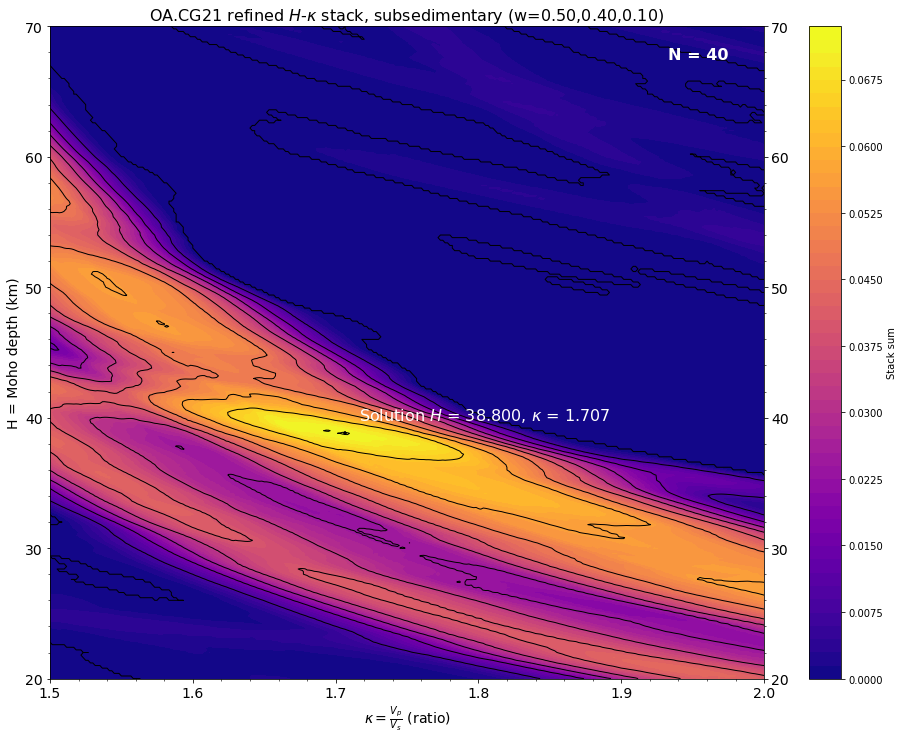

In [124]:
k_grid, h_grid, hk = rf_stacking.compute_hk_stack(rf_stream_noreverb, include_t3=True,
                                                  root_order=2, k_range=np.linspace(1.5, 2.0, 301), V_p=6.4)
w = (0.5, 0.4, 0.1)
w_str = "w={:1.2f},{:1.2f},{:1.2f}".format(*w)
stack = rf_stacking.compute_weighted_stack(hk, weighting=w)
hk_fig = rf_plot_utils.plot_hk_stack(k_grid, h_grid, stack, num=len(rf_stream_noreverb),
                                     title="{}.{} refined $H$-$\kappa$ stack, subsedimentary ({})".format(
                                         network, target_station, w_str))

H_crust, k_crust = rf_stacking.find_global_hk_maximum(k_grid, h_grid, stack)
print('Subsedimentary crustal H-k solution: H = {}, k = {}'.format(H_crust, k_crust))
#***************
# Override
if target_station == 'CG23':
    H_crust, k_crust = 35, 1.75
elif target_station == 'CH21':
    H_crust, k_crust = 37, 1.62
elif target_station == 'CI23':
    H_crust, k_crust = 33, 1.71
elif target_station == 'CJ27':
    H_crust, k_crust = 33, 1.59
#***************
plt.scatter(k_crust, H_crust, marker='+', c="#000000", s=20)
if k_crust >= 1.75:
    plt.text(k_crust - 0.01, H_crust + 1, "Solution $H$ = {:.3f}, $\kappa$ = {:.3f}".format(H_crust, k_crust),
             color="#ffffff", fontsize=16, horizontalalignment='right')
else:
    plt.text(k_crust + 0.01, H_crust + 1, "Solution $H$ = {:.3f}, $\kappa$ = {:.3f}".format(H_crust, k_crust),
             color="#ffffff", fontsize=16)
# end if

if save_files:
    hk_fig.savefig("{}.{}_Hk_stack_subsediment.png".format(network, target_station), dpi=300)

plt.show()

## Perform shallow $H-k$ stacking to determine sedimentary thickness

In [125]:
# V_p = rf_stacking.infer_Vp_from_traces(channel_data_noreverb)
# print("Inferred V_p = {}".format(V_p))
V_p = 6.4

# Assume V-p in sedimentary layer.
# (Yu used 3.6 km/s or 2.1 km/s based on empirical data.)
V_p_sediment = 2.1

In [126]:
for i, tr in enumerate(rf_stream_noreverb):
    _, t2_subsediment, t3_subsediment = rf_stacking.compute_theoretical_phase_times(tr, H_crust, k_crust, V_p)
    tr.stats.sediment = {'t1_offset': 0.0,
                         't2_offset': t2_subsediment,
                         't3_offset': t3_subsediment}

Sedimentary layer H-k solution: H = 0.37440000000000007, k = 5.470000000000001


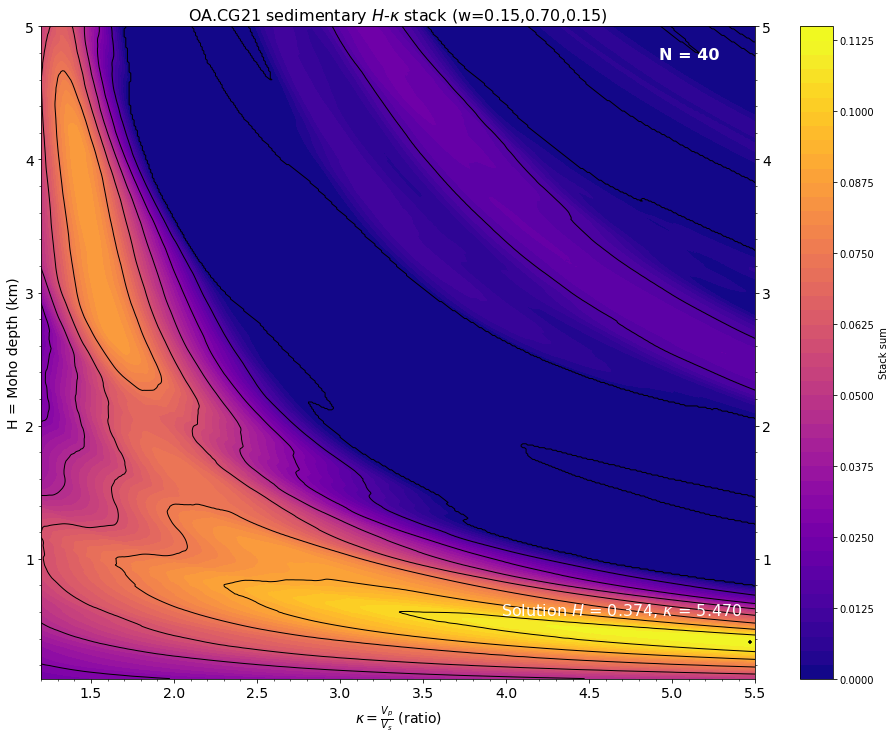

In [128]:
k_grid, h_grid, hk = rf_stacking.compute_hk_stack(rf_stream_noreverb, V_p=V_p_sediment,
                                                  h_range=np.linspace(0.1, 5.0, 501),
                                                  k_range=np.linspace(1.2, 5.5, 431),
                                                  root_order=2, include_t3=True)
w = (0.15, 0.7, 0.15)
w_str = "w={:1.2f},{:1.2f},{:1.2f}".format(*w)
stack = rf_stacking.compute_weighted_stack(hk, weighting=w)
hk_fig = rf_plot_utils.plot_hk_stack(k_grid, h_grid, stack, num=len(rf_stream_noreverb),
                                     title="{}.{} sedimentary $H$-$\kappa$ stack ({})".format(
                                         network, target_station, w_str))

H_sediment, k_sediment = rf_stacking.find_global_hk_maximum(k_grid, h_grid, stack)
print('Sedimentary layer H-k solution: H = {}, k = {}'.format(H_sediment, k_sediment))
plt.scatter(k_sediment, H_sediment, marker='+', c="#000000", s=20)
if k_sediment >= 3.5:
    plt.text(k_sediment - 0.05, H_sediment + 0.2, "Solution $H$ = {:.3f}, $\kappa$ = {:.3f}".format(H_sediment, k_sediment),
             color="#ffffff", fontsize=16, horizontalalignment='right')
else:
    plt.text(k_sediment + 0.05, H_sediment + 0.2, "Solution $H$ = {:.3f}, $\kappa$ = {:.3f}".format(H_sediment, k_sediment),
             color="#ffffff", fontsize=16)
# end if

if save_files:
    hk_fig.savefig("{}.{}_Hk_stack_sediment.png".format(network, target_station), dpi=300)

plt.show()

In [ ]:
print("Total estimated Moho depth, H = {} km (below sediment of {} km)".format(H_sediment + H_crust, H_sediment))